## Loading

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss

import helper 
from models import *


current_path = os.getcwd()

SEED = 2023

# Define a context manager to temporarily suppress FutureWarnings
class SuppressFutureWarnings:
    def __enter__(self):
        warnings.filterwarnings('ignore', category=FutureWarning)
    
    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filterwarnings('default')

In [10]:
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", "DIA", "^TNX"]
start_date = "2010-01-01"
end_date = "2023-01-01"
stock_data = {}
MAs = [5, 10, 20, 50, 100, 200]

for stock in STOCKS: 
    try:
        data_path = os.path.join(current_path, "data", f"{stock}_{start_date}_{end_date}.csv")
        data = pd.read_csv(data_path)
        data['Date'] = pd.to_datetime(data['Date'])
        if stock != "^TNX":
            data['rsi_class'] = helper.compute_rsi_class(data)  # Assuming you have this function in helper
            data['volume_class'] = helper.compute_volume_class(data)  # Add volume analysis
            data = helper.calculate_mas(data, MAs, column_name="Close")
            data['WVAD'] = helper.calculate_wvad(data, period=14)
            data['ROC'] = helper.calculate_roc(data, period=14)
            data['MACD'], data['macd_line'], data['signal_line'] = helper.calculate_macd(data, short_window=12, long_window=26, signal_window=9)
            data['CCI'] =  helper.calculate_cci(data, period=20)
            data['Upper Band'], data['Lower Band'], data['SMA'] = helper.calculate_bollinger_bands(data, window=20, num_std_dev=2)
            data['SMI'] = helper.calculate_smi(data, period=14, signal_period=3)
            data['ATR'] = helper.calculate_atr(data, period=14)
            data[['WVF', 'upperBand', 'rangeHigh', 'WVF_color']] = helper.cm_williams_vix_fix(data['Close'], data['Low'])
            data[['Buy_Signal', 'Sell_Signal', 'BB_Upper', 'BB_Lower']] = helper.bollinger_rsi_strategy(data['Close'])
            data = helper.on_balance_volume(data)
            data = helper.volume_price_trend(data)
            data = helper.money_flow_index(data)
            data = helper.accumulation_distribution(data)
        data['returns'] = data['Close'].pct_change() * 100
        data = data.dropna()
        stock_data[stock] = data
        print(f"Data fetched for {stock}")
    except Exception as e:
        print(f"Error fetching data for {stock}: {str(e)}")

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^TNX


In [11]:
weekly_returns = {}
for stock, data in stock_data.items():
    # No need to reconvert 'Date' to datetime, it should already be in the correct format
    data.set_index('Date', inplace=True)
    
    # Use the 'Close' column directly for resampling
    weekly_data = data['Close'].resample('W-FRI').last()  # This will align weekly data to end on Friday
    weekly_returns[stock] = weekly_data.pct_change() * 100  # Calculate the weekly returns

    # Drop NaN values that result from pct_change()
    weekly_returns[stock] = weekly_returns[stock].dropna()

    # Calculate statistics
    max_return = weekly_returns[stock].max()
    min_return = weekly_returns[stock].min()
    mean_return = weekly_returns[stock].mean()
    median_return = weekly_returns[stock].median()
    std_deviation = weekly_returns[stock].std()

    # Print the statistics for each stock
    print(f"Statistics for {stock}:")
    print(f"Mean Weekly Return: {mean_return:.2f}%")
    print(f"Standard Deviation of Weekly Returns: {std_deviation:.2f}%")
    print("-" * 40)

Statistics for TSLA:
Mean Weekly Return: 0.99%
Standard Deviation of Weekly Returns: 7.71%
----------------------------------------
Statistics for AAPL:
Mean Weekly Return: 0.46%
Standard Deviation of Weekly Returns: 3.89%
----------------------------------------
Statistics for QQQ:
Mean Weekly Return: 0.29%
Standard Deviation of Weekly Returns: 2.63%
----------------------------------------
Statistics for SPY:
Mean Weekly Return: 0.21%
Standard Deviation of Weekly Returns: 2.30%
----------------------------------------
Statistics for MSFT:
Mean Weekly Return: 0.41%
Standard Deviation of Weekly Returns: 3.23%
----------------------------------------
Statistics for AMZN:
Mean Weekly Return: 0.45%
Standard Deviation of Weekly Returns: 4.31%
----------------------------------------
Statistics for GOOG:
Mean Weekly Return: 0.34%
Standard Deviation of Weekly Returns: 3.67%
----------------------------------------
Statistics for DIA:
Mean Weekly Return: 0.20%
Standard Deviation of Weekly Ret

## Stationarity Check

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


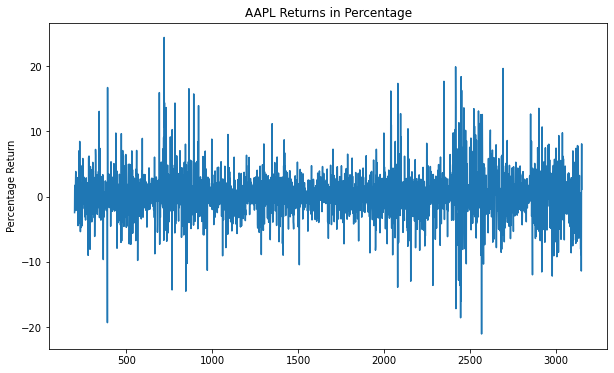

ADF Statistic: -54.823601426692676
p-value: 0.0
Critical Value (1%): -3.4325686438295246
Critical Value (5%): -2.862520250798378
Critical Value (10%): -2.567291814306234


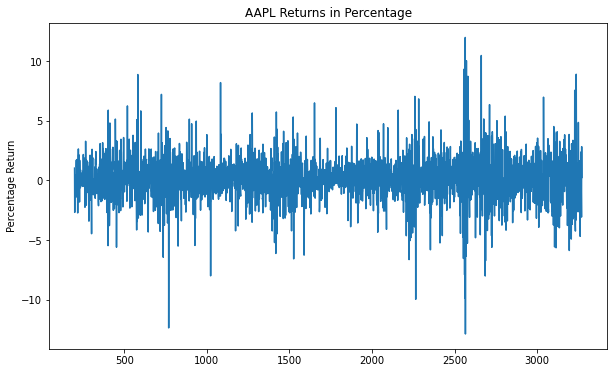

ADF Statistic: -11.10849504067465
p-value: 3.710752482673147e-20
Critical Value (1%): -3.4324951361310974
Critical Value (5%): -2.862487785002662
Critical Value (10%): -2.567274529885855


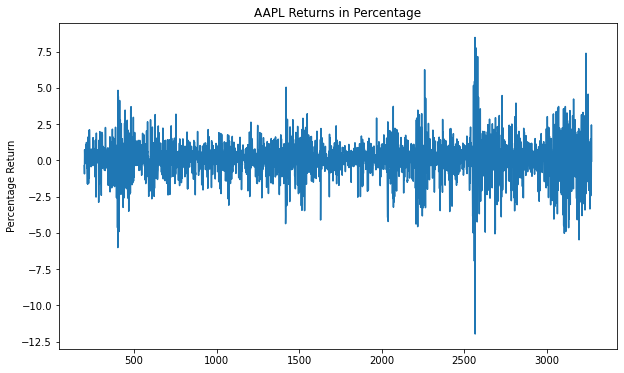

ADF Statistic: -12.267937552952551
p-value: 8.773166260203737e-23
Critical Value (1%): -3.4324979545720318
Critical Value (5%): -2.862489029824813
Critical Value (10%): -2.5672751926125317


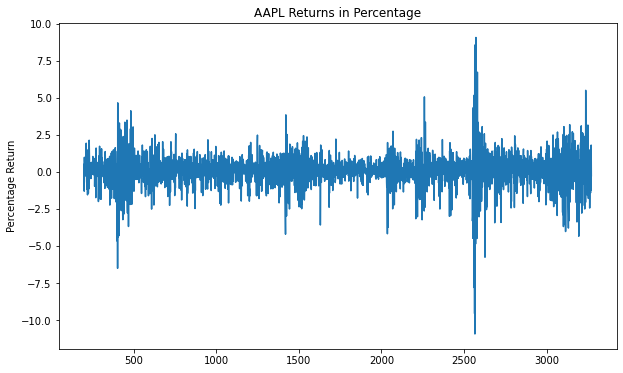

ADF Statistic: -12.105367199076817
p-value: 1.9746502049666403e-22
Critical Value (1%): -3.432498660339858
Critical Value (5%): -2.862489341541441
Critical Value (10%): -2.5672753585663295


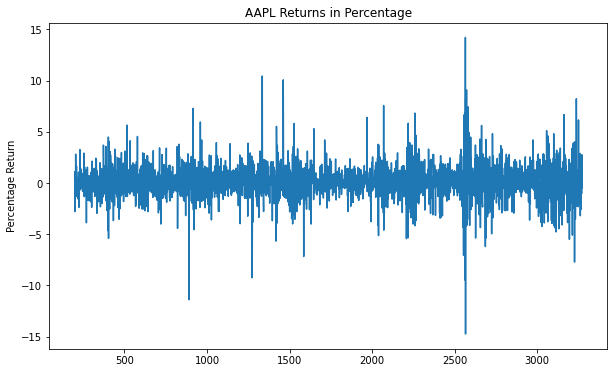

ADF Statistic: -20.11811146118734
p-value: 0.0
Critical Value (1%): -3.432486027062847
Critical Value (5%): -2.862483761788108
Critical Value (10%): -2.567272387981546


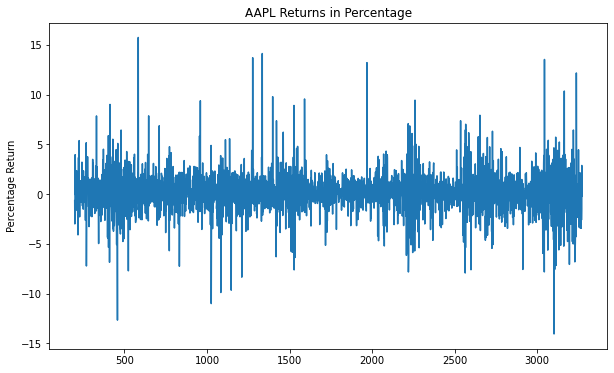

ADF Statistic: -56.162741541106
p-value: 0.0
Critical Value (1%): -3.4324804598338967
Critical Value (5%): -2.862481302896484
Critical Value (10%): -2.5672710789023507


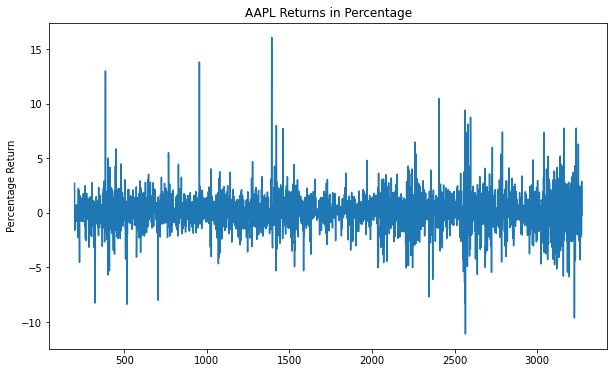

ADF Statistic: -19.19156948573188
p-value: 0.0
Critical Value (1%): -3.432486027062847
Critical Value (5%): -2.862483761788108
Critical Value (10%): -2.567272387981546


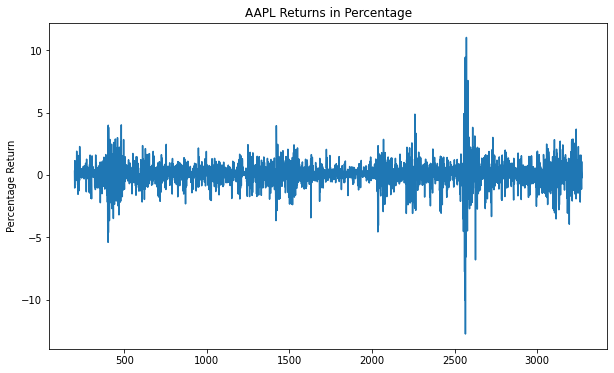

ADF Statistic: -11.873841087592124
p-value: 6.40975231976363e-22
Critical Value (1%): -3.432498660339858
Critical Value (5%): -2.862489341541441
Critical Value (10%): -2.5672753585663295


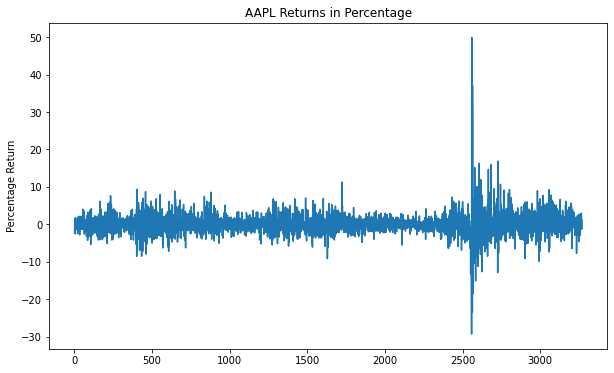

ADF Statistic: -9.297344521698388
p-value: 1.1367267347258507e-15
Critical Value (1%): -3.4323711524522436
Critical Value (5%): -2.8624330239086477
Critical Value (10%): -2.5672453760070444


In [50]:
for item in stock_data.keys():
    returns = stock_data[item]['returns']

    returns.plot(title='AAPL Returns in Percentage', figsize=(10, 6))
    plt.ylabel('Percentage Return')
    plt.show()
    adf_result = adfuller(returns.dropna())  # Make sure there are no NaN values in the series
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    for key, value in adf_result[4].items():
        print(f'Critical Value ({key}): {value}')

## Model

### XGBoost

#### APPLE

In [62]:
fromDate = "2010-01-01"
toDate = '2023-01-01'
# fromDate = "2015-01-01"
# toDate = '2017-01-01'
stock = 'AAPL'
window_size = 200
lag = 5
starting_funds = 50000
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'

with SuppressFutureWarnings():
    xgboost_model = XGBoostModel(loss_fn)
    xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, lag=lag)
    xgboost_stock_predictor.fit_predict()
    xgboost_stock_predictor.print_metrics()

Processing: 100%|██████████| 2856/2856 [04:11<00:00, 11.35it/s]

Mean Squared Error (MSE): 4.524703185921866
Mean Absolute Percentage Error (MAPE): 1.87%
Root Mean Squared Error (RMSE): 2.1271349712516754
Mean Absolute Error (MAE): 1.158782253078386


In [63]:
actual_returns = helper.calculate_returns(xgboost_stock_predictor.true_values)
predicted_returns = helper.calculate_returns(xgboost_stock_predictor.predictions)
min_length = min(len(actual_returns), len(predicted_returns))
mae_in_return = mean_absolute_error(actual_returns[:min_length], predicted_returns[:min_length])
mse_in_return = mean_squared_error(actual_returns[:min_length], predicted_returns[:min_length])

print(mse_in_return, '\n')
print(mae_in_return)


7.950598627247912 

2.0347887244557756


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


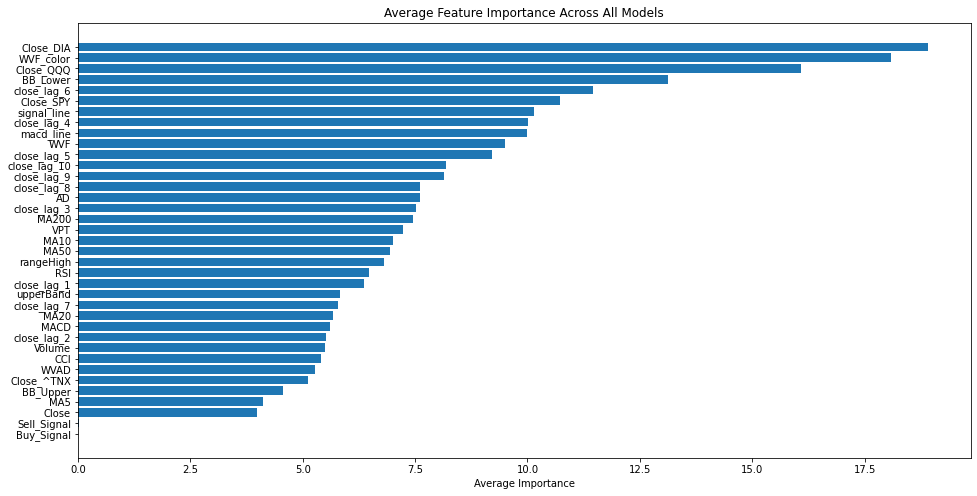

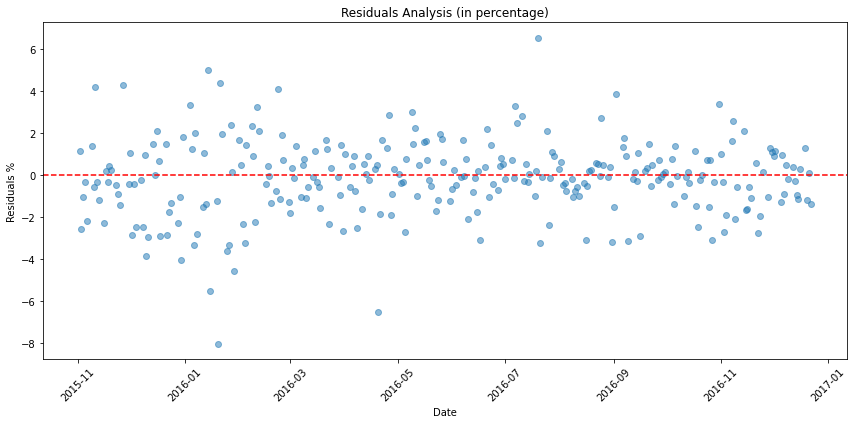

In [43]:
xgboost_stock_predictor.show_feature_importance()
xgboost_stock_predictor.plot_residuals()

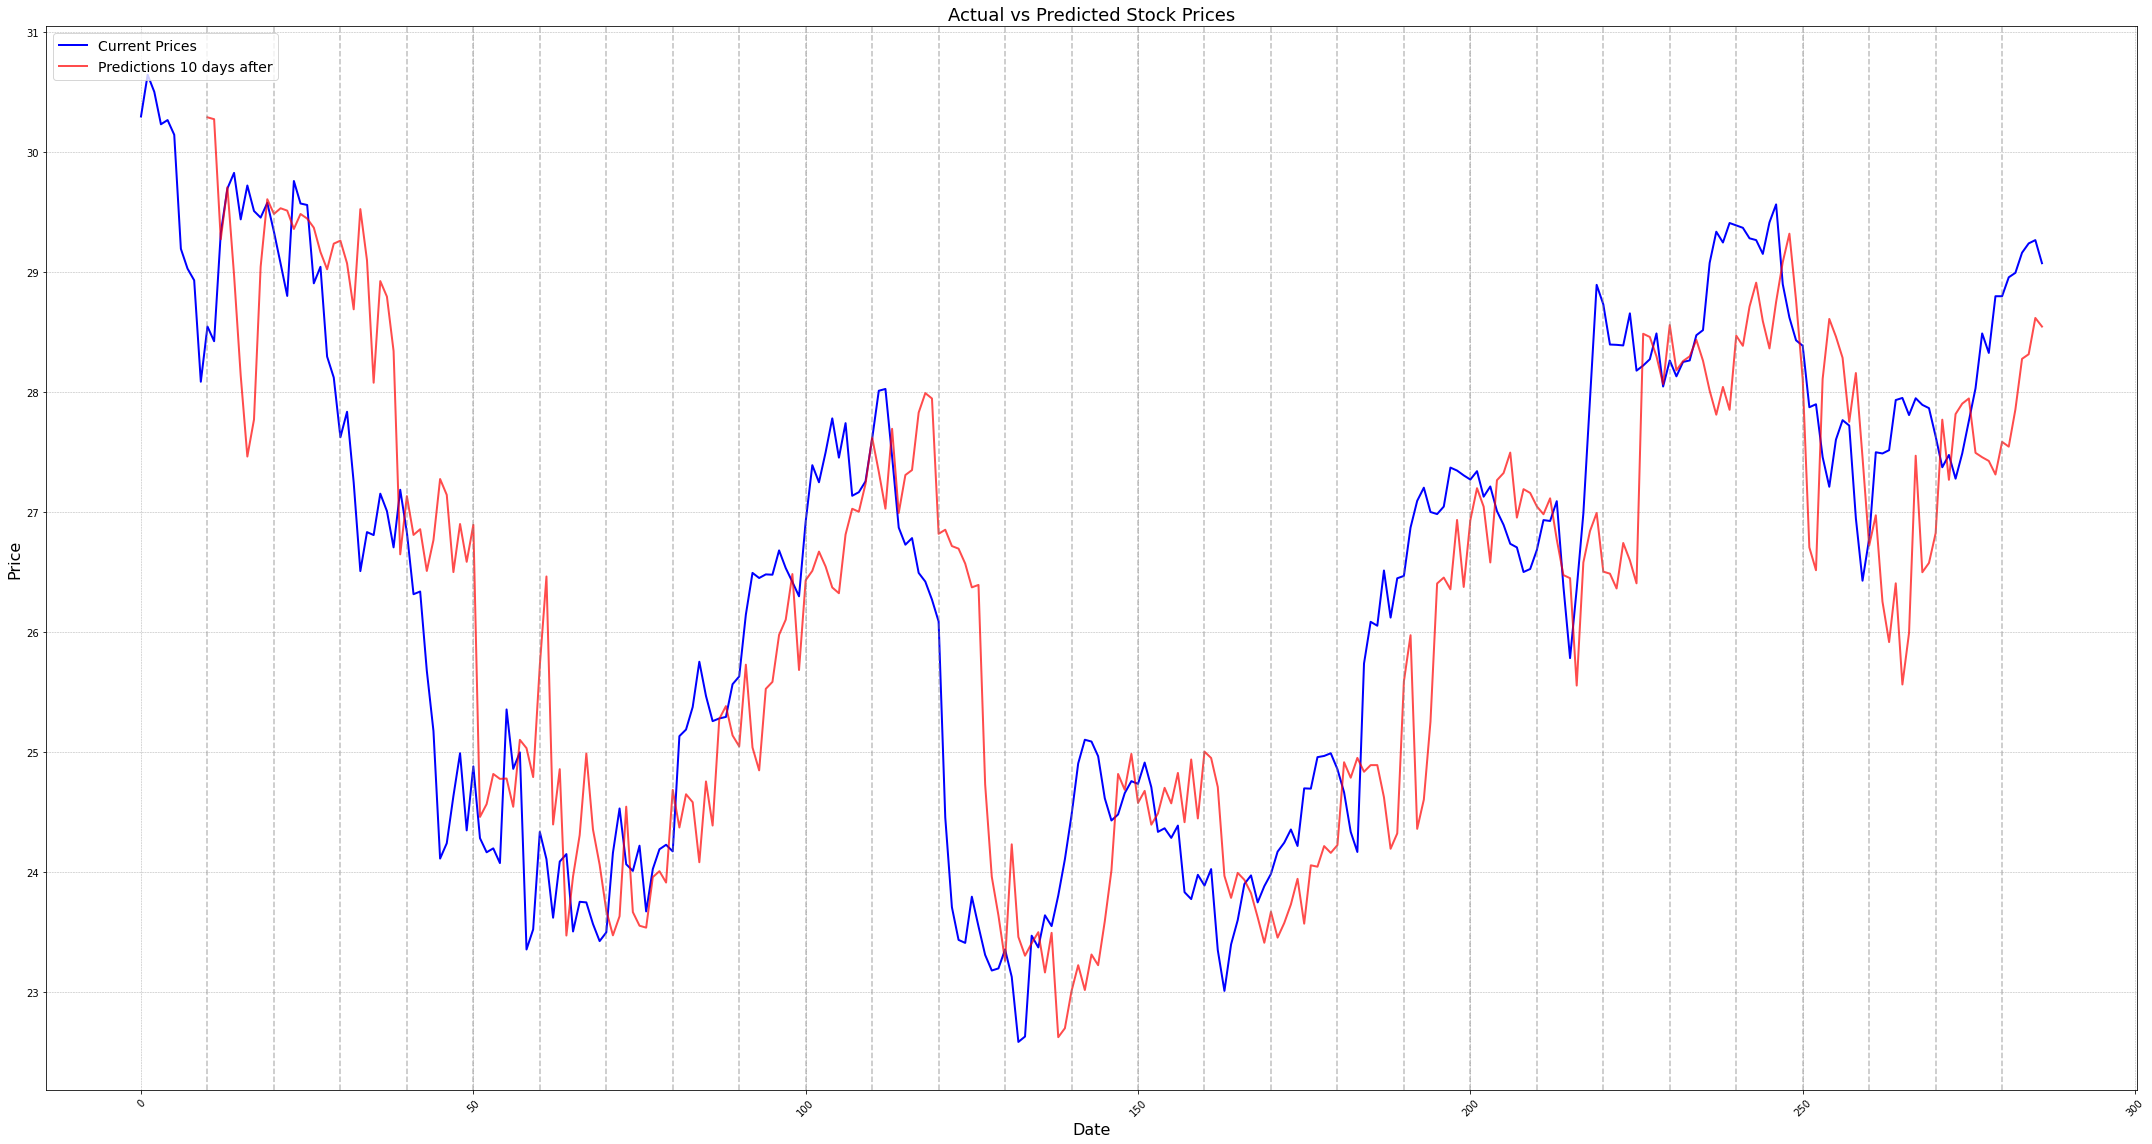

In [6]:
xgboost_stock_predictor.plot_actual_vs_predicted(prediction_lag=10)

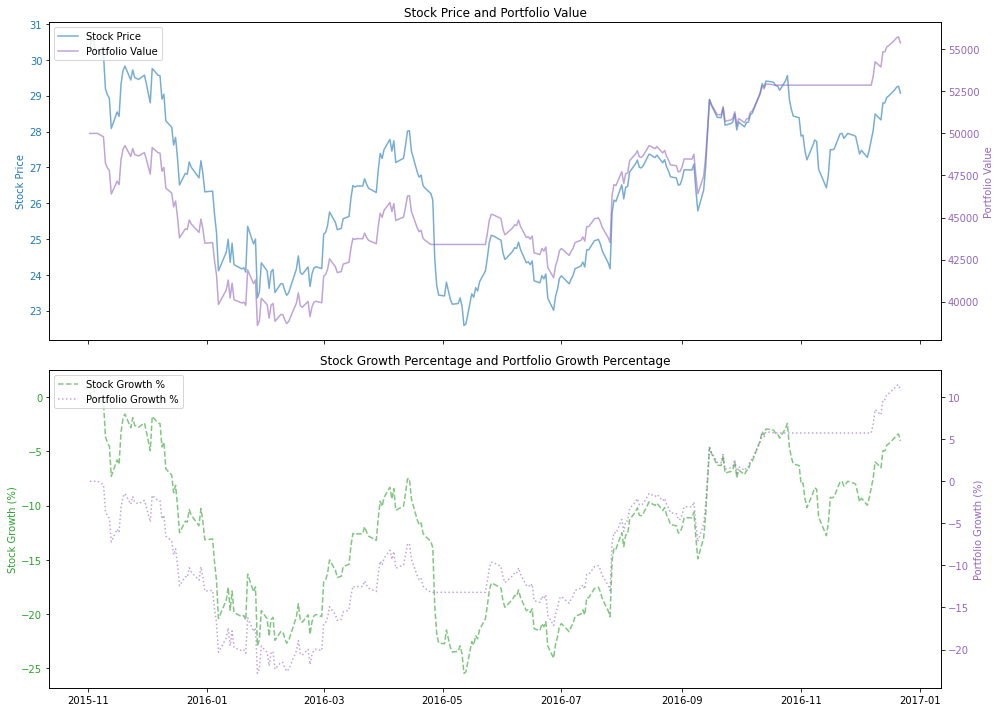

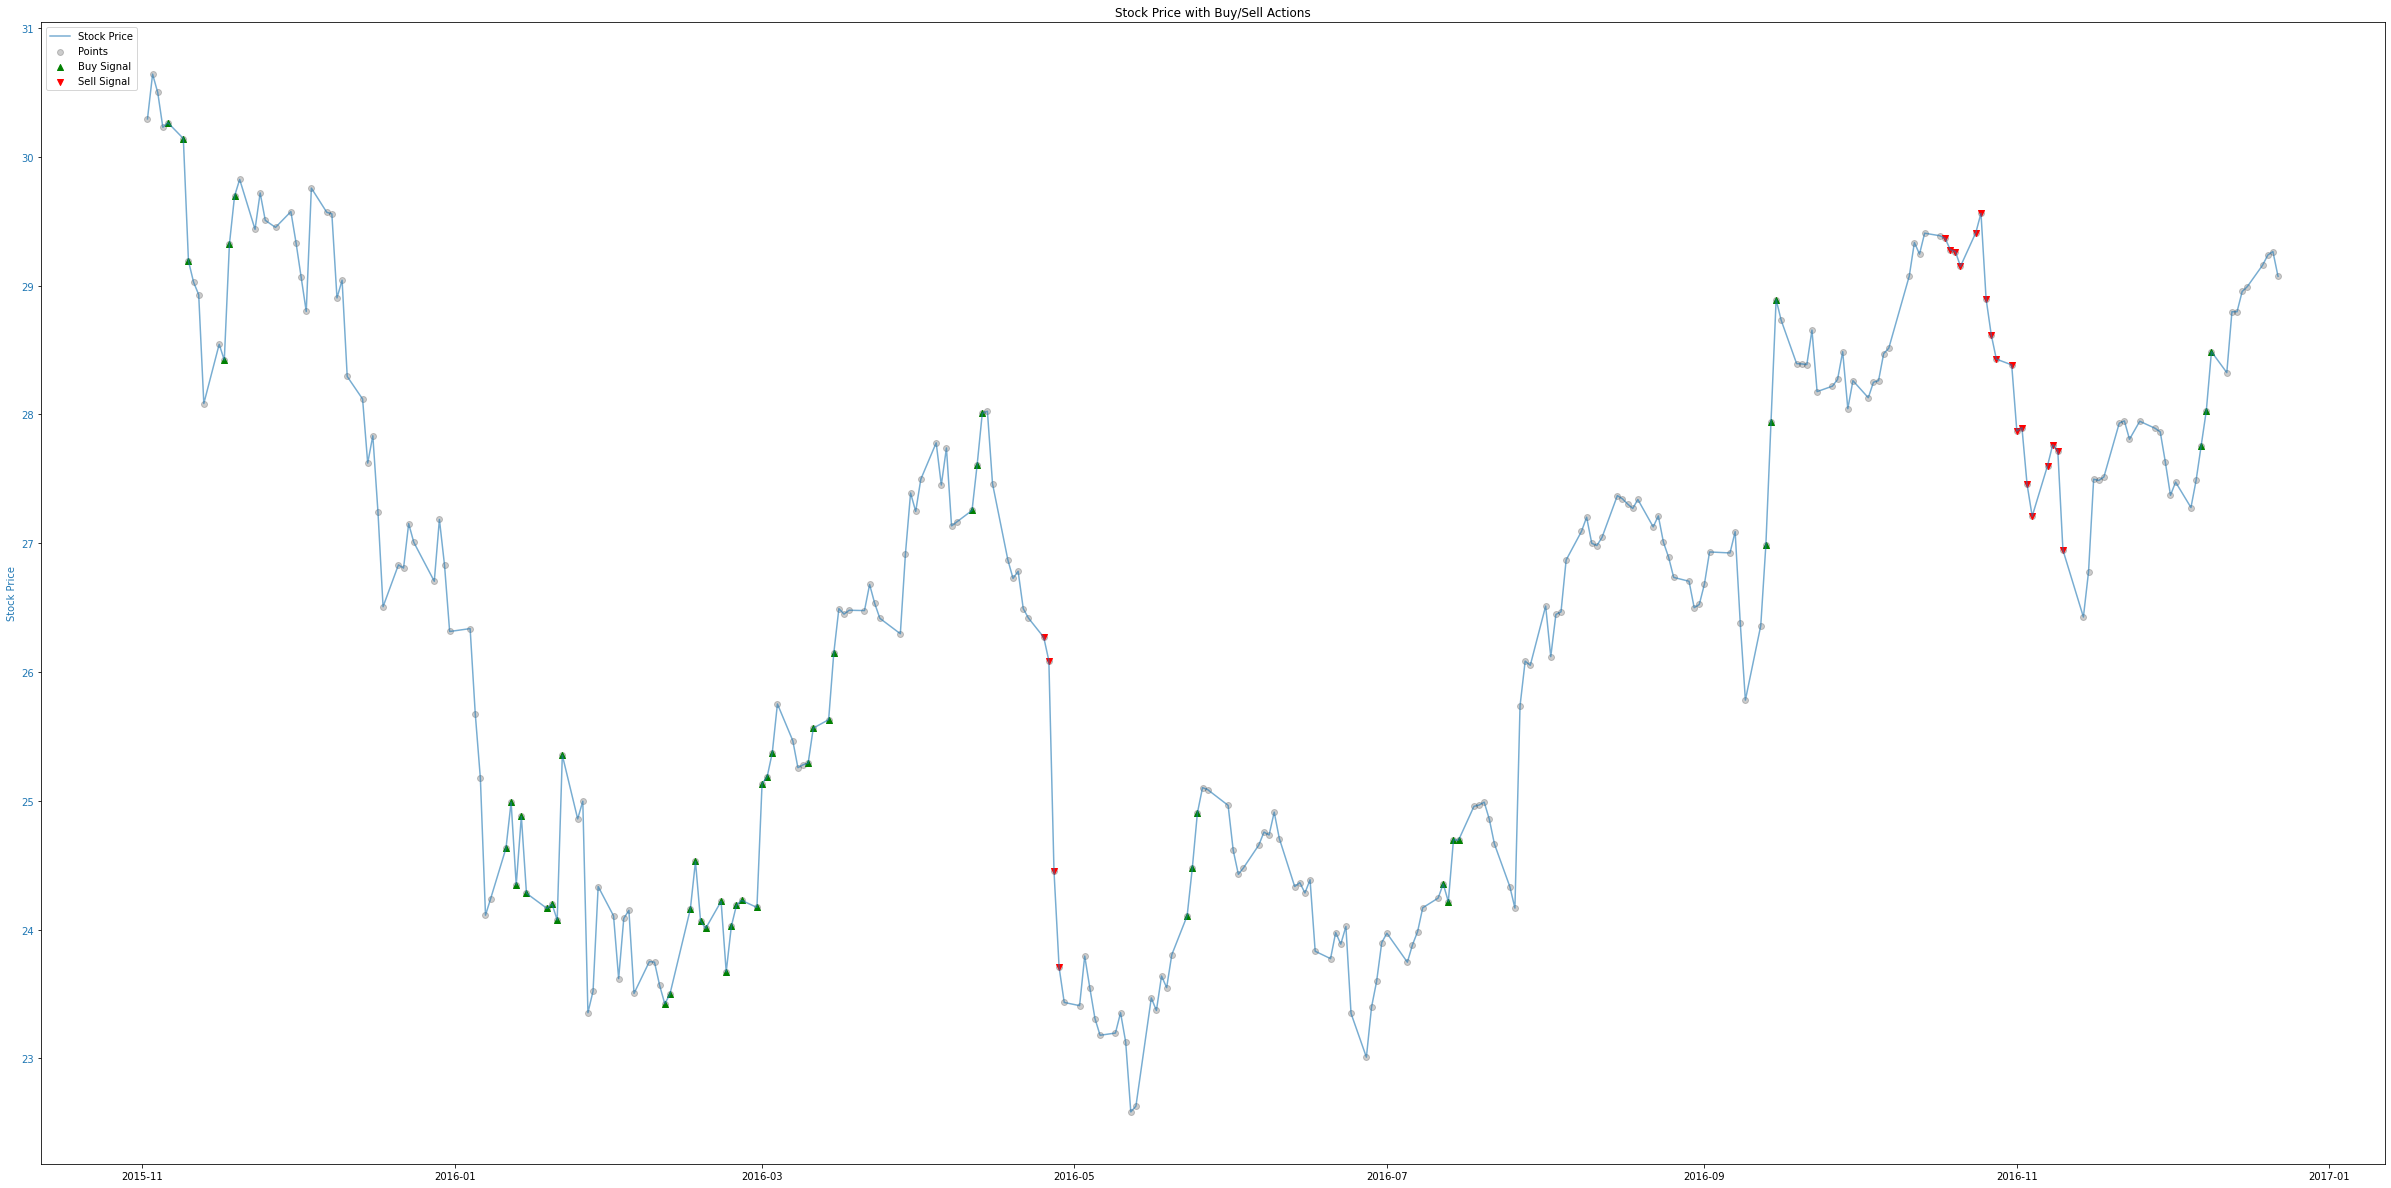

In [7]:
xgboost_stock_predictor.trading_strategy(window_size=window_size, starting_funds=starting_funds)

#### window size analysis 

In [24]:
fromDate = "2010-01-01"
toDate = '2023-01-01'
stock = 'AAPL'
window_sizes = [5, 10, 20, 40, 80, 160, 320, 640, 1280, 2560]
late = 5
starting_funds = 50000
loss_fn = 'reg:squarederror'  # 'reg:pseudohubererror'

mape_values = []

with SuppressFutureWarnings():
    xgboost_model = XGBoostModel(loss_fn)
    for window in window_sizes:
        xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window, late=late)
        xgboost_stock_predictor.fit_predict()
        xgboost_stock_predictor.print_metrics()
        mape_values.append(xgboost_stock_predictor.MAPE)

Processing: 100%|██████████| 3061/3061 [01:34<00:00, 32.39it/s]


Mean Squared Error (MSE): 3.458906869890099
Mean Absolute Percentage Error (MAPE): 1.64%
Root Mean Squared Error (RMSE): 1.8598136653681463


Processing: 100%|██████████| 3056/3056 [01:36<00:00, 31.70it/s]


Mean Squared Error (MSE): 4.139131158662535
Mean Absolute Percentage Error (MAPE): 1.77%
Root Mean Squared Error (RMSE): 2.0344854776238965


Processing: 100%|██████████| 3046/3046 [01:44<00:00, 29.11it/s]


Mean Squared Error (MSE): 3.8624051315141092
Mean Absolute Percentage Error (MAPE): 1.76%
Root Mean Squared Error (RMSE): 1.9653002649758406


Processing: 100%|██████████| 3026/3026 [01:58<00:00, 25.48it/s]


Mean Squared Error (MSE): 3.9433788198004485
Mean Absolute Percentage Error (MAPE): 1.72%
Root Mean Squared Error (RMSE): 1.9857942541462972


Processing: 100%|██████████| 2986/2986 [02:03<00:00, 24.16it/s]


Mean Squared Error (MSE): 3.8313669424375485
Mean Absolute Percentage Error (MAPE): 1.73%
Root Mean Squared Error (RMSE): 1.9573877854011321


Processing: 100%|██████████| 2906/2906 [02:31<00:00, 19.24it/s]


Mean Squared Error (MSE): 4.503407679129165
Mean Absolute Percentage Error (MAPE): 1.88%
Root Mean Squared Error (RMSE): 2.122123389232861


Processing: 100%|██████████| 2746/2746 [03:28<00:00, 13.16it/s]


Mean Squared Error (MSE): 5.0816745281772855
Mean Absolute Percentage Error (MAPE): 1.98%
Root Mean Squared Error (RMSE): 2.2542569791790124


Processing: 100%|██████████| 2426/2426 [04:28<00:00,  9.04it/s]


Mean Squared Error (MSE): 5.6436716158188105
Mean Absolute Percentage Error (MAPE): 1.99%
Root Mean Squared Error (RMSE): 2.37564130622003


Processing: 100%|██████████| 1786/1786 [05:11<00:00,  5.74it/s]


Mean Squared Error (MSE): 7.200468082765067
Mean Absolute Percentage Error (MAPE): 2.04%
Root Mean Squared Error (RMSE): 2.6833687936556663


Processing: 100%|██████████| 506/506 [02:29<00:00,  3.38it/s]

Mean Squared Error (MSE): 18.30975751733691
Mean Absolute Percentage Error (MAPE): 2.23%
Root Mean Squared Error (RMSE): 4.278990245062134


ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

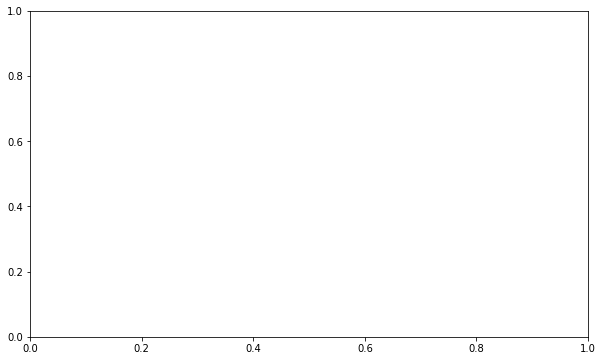

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(window_sizes[:len(mape_values)], mape_values, marker='o', linestyle='-')
plt.xlabel('Window Size')
plt.ylabel('MAPE')
plt.title('Effect of Window Size on MAPE')
plt.grid(True)
plt.show()

#### performance in various stocks

In [25]:
min_mape_value = min(mape_values)
optimal_window_size = window_sizes[mape_values.index(min_mape_value)]
for stock in ["TSLA", "AAPL", "MSFT", "AMZN", "GOOG"]:
    # fromDate = "2015-01-01"
    # toDate = '2017-01-01'
    fromDate = "2010-01-01"
    toDate = '2023-01-01'
    window_size = optimal_window_size
    late = 5
    starting_funds = 50000
    loss_fn = 'reg:squarederror' #'reg:pseudohubererror'

    with SuppressFutureWarnings():
        print(stock)
        xgboost_model = XGBoostModel(loss_fn)
        xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, late=late)
        xgboost_stock_predictor.fit_predict()
        xgboost_stock_predictor.print_metrics()
        print("==="*9)


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TSLA


Processing: 100%|██████████| 2939/2939 [01:27<00:00, 33.45it/s]


Mean Squared Error (MSE): 32.22608128946541
Mean Absolute Percentage Error (MAPE): 3.16%
Root Mean Squared Error (RMSE): 5.676802030145618
AAPL


Processing: 100%|██████████| 3061/3061 [01:31<00:00, 33.35it/s]


Mean Squared Error (MSE): 3.458906869890099
Mean Absolute Percentage Error (MAPE): 1.64%
Root Mean Squared Error (RMSE): 1.8598136653681463
MSFT


Processing: 100%|██████████| 3061/3061 [01:32<00:00, 33.26it/s]


Mean Squared Error (MSE): 11.11895563102922
Mean Absolute Percentage Error (MAPE): 1.46%
Root Mean Squared Error (RMSE): 3.3345098037086682
AMZN


Processing: 100%|██████████| 3061/3061 [01:31<00:00, 33.41it/s]


Mean Squared Error (MSE): 5.597891600063091
Mean Absolute Percentage Error (MAPE): 1.87%
Root Mean Squared Error (RMSE): 2.3659863905067358
GOOG


Processing: 100%|██████████| 3061/3061 [01:31<00:00, 33.42it/s]

Mean Squared Error (MSE): 2.3202525681606776
Mean Absolute Percentage Error (MAPE): 1.51%
Root Mean Squared Error (RMSE): 1.5232375284769863


### LSTM, inspired by A deep learning framework for financial time series using stacked autoencoders and longshort term memory

## other

In [8]:
def determine_trend(df, short_window=50, long_window=200, threshold=0.01):
    """
    Determine the trend based on moving averages.
    
    Parameters:
    - df: DataFrame with the stock data
    - short_window: Window for the short-term SMA
    - long_window: Window for the long-term SMA
    - threshold: Percentage difference between SMAs to consider as 'No trend'
    
    Returns:
    - trend: List with 'Uptrend', 'Downtrend' or 'No trend' for each row in df
    """
    # Calculate short and long moving averages
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

    # Calculate the trend
    conditions = [
        (df['Short_MA'] > df['Long_MA'] * (1 + threshold)), # Uptrend condition
        (df['Short_MA'] < df['Long_MA'] * (1 - threshold))  # Downtrend condition
    ]
    choices = ['Uptrend', 'Downtrend']
    
    df['Trend'] = np.select(conditions, choices, default='No trend')
    
    return df['Trend'].tolist()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
stock_apple = stock_data['AAPL'].copy()
stock_apple['Trend'] = determine_trend(stock_apple)


In [10]:
def plot_stock_with_trend(df):
    apdict = [mpf.make_addplot(df['Short_MA'], color='blue', linestyle='--'),
              mpf.make_addplot(df['Long_MA'], color='red', linestyle='--')]
    
    mpf.plot(df, type='candle', style='yahoo', volume=True, title='Stock with Trend Indicator',
             ylabel='Price', figratio=(400, 120), mav=(100, 400), addplot=apdict, 
             hlines=dict(hlines=[df['Close'].mean()], colors=['blue'], linewidths=[2]))

plot_stock_with_trend(stock_apple)


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: Expect data.index as DatetimeIndex

In [ ]:
# Calculate the weekly return
stock_apple['Weekly_Return'] = stock_apple['Close'].resample('W').ffill().pct_change()


# Display statistics
stats = stock_apple['Weekly_Return'].describe()
stats